<a href="https://colab.research.google.com/github/Awerdos/Anomaly-Detection-with-AutoEncoder/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [46]:
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 64

dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=transform)
data = dataset.data

mask_normal = np.where(dataset.targets == 4)[0]
mask_anomaly = np.where(dataset.targets != 4)[0]

trainset = torch.utils.data.Subset(dataset, mask_normal)
testset = torch.utils.data.Subset(dataset, mask_anomaly)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)


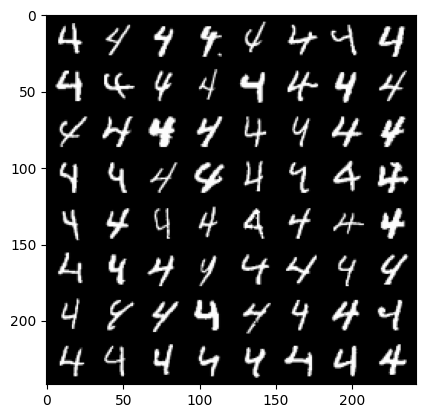

In [47]:
def imshow(img):
  # img = img/2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [48]:
class AutoEncoder_convolutional(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 7)
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
    )

  def forward(self,x):
    compressed = self.encoder(x)
    decompressed = self.decoder(compressed)
    return decompressed

In [53]:
class AutoEncoder_linear(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64)
    )

    self.decoder = nn.Sequential(
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Sigmoid()
    )

  def forward(self,x):
    x = torch.flatten(x, start_dim=1)
    compressed = self.encoder(x)
    decompressed = self.decoder(compressed)
    decompressed = decompressed.view(-1,1,28,28)
    return decompressed

In [50]:
def E(x_pred,x):
  return torch.mean((x - x_pred) ** 2)

In [61]:
def train_model(model, num_epoch):
  print(f"Model: {model.__class__.__name__}")

  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  for epoch in range(num_epoch):
    running_loss = 0.0

    for i,data in enumerate(trainloader):
      input, _ = data

      optimizer.zero_grad()

      forward = model(input)
      loss = E(forward, input)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    print(f'[{epoch + 1}/{num_epoch}] loss: {running_loss / len(trainloader):.3f}')

  print("Finished Training")

In [62]:
conv_model = AutoEncoder_convolutional()
linear_model = AutoEncoder_linear()

models = [linear_model,conv_model]
num_epochs = 5

for model in models:
  train_model(model,num_epochs)



Model: AutoEncoder_linear
[1/5] loss: 0.075
[2/5] loss: 0.050
[3/5] loss: 0.037
[4/5] loss: 0.029
[5/5] loss: 0.026
Finished Training
Model: AutoEncoder_convolutional
[1/5] loss: 0.094
[2/5] loss: 0.054
[3/5] loss: 0.038
[4/5] loss: 0.020
[5/5] loss: 0.015
Finished Training


In [ ]:
with torch.no_grad():
  loss_array_normal = []
  for i ,data in enumerate(trainset):
      images, _ = data
      forward = model(images)
      loss = E(forward, images)
      loss_array_normal.append(loss.item())

In [ ]:
std = np.std(np.array(loss_array_normal))
mean = np.mean(np.array(loss_array_normal))
k = 2

T = mean + std*k
print(f"T: {T}")
print(len(loss_array_normal))

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

with torch.no_grad():
    forward = model(images)
    loss = E(forward, images)
    print(f"Loss: {loss}")
    if loss > T:
      print("Anomaly")
    else:
      print("Normal")

imshow(torchvision.utils.make_grid(forward))
imshow(torchvision.utils.make_grid(images))

In [ ]:
with torch.no_grad():
  loss_array_anomaly = []
  for i ,data in enumerate(testset):
      images, _ = data
      forward = model(images)
      loss = E(forward, images)
      loss_array_anomaly.append(loss.item())


In [ ]:
hisogramdata = np.where(np.array(loss_array_anomaly) > T, "Anomaly", "Normal")
num_normal = len(np.where(hisogramdata == "Normal")[0])
num_anomaly = len(np.where(hisogramdata == "Anomaly")[0])

G = num_normal / (num_normal + num_anomaly)
print(f"G: {G}")

plt.hist(hisogramdata, bins=2)
plt.show()

In [ ]:
plt.hist(loss_array_anomaly)
plt.hist(loss_array_normal)
plt.show()

In [ ]:
model = AutoEncoder_linear()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epoch = 5

for epoch in range(num_epoch):
  running_loss = 0.0

  for i,data in enumerate(trainloader):
    input, _ = data
    input = torch.flatten(input, start_dim=1)

    optimizer.zero_grad()

    forward = model(input)
    loss = E(forward, input)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f'[{epoch + 1}/{num_epoch}] loss: {running_loss / len(trainloader):.3f}')

print("Finished Training")